## Apiux & SII: Fuerza entre entidades tributaria relacionada a probabilidad de contaminacion, definicion en base a IVA.
## Henry Vega (henrry.vega@api-ux.com)
## Data scientist

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
import pyspark
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

from pyspark_dist_explore import hist
import matplotlib.pyplot as plt
from pyspark.sql.types import StringType,TimestampType

In [2]:
spark = SparkSession.builder \
  .appName("Test")  \
  .config("spark.yarn.access.hadoopFileSystems","abfs://data@datalakesii.dfs.core.windows.net/") \
  .config("spark.executor.memory", "24g") \
  .config("spark.driver.memory", "12g")\
  .config("spark.executor.cores", "12") \
  .config("spark.executor.instances", "24") \
  .config("spark.driver.maxResultSize", "12g") \
  .getOrCreate()

warnings.filterwarnings('ignore', category=DeprecationWarning)
sc=spark.sparkContext
sc.setLogLevel ('ERROR')

24/04/29 15:50:23 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
24/04/29 15:50:23 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
Setting spark.hadoop.yarn.resourcemanager.principal to yasser.nanjari
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/29 15:50:23 WARN SparkConf: The configuration key 'spark.yarn.access.hadoopFileSystems' has been deprecated as of Spark 3.0 and may be removed in the future. Please use the new key 'spark.kerberos.access.hadoopFileSystems' instead.
24/04/

En primer lugar, leemos la data de los arcos comerciales correspondientes.

In [8]:
Carpeta = "Proceso Renta 2024/"
Archivo = "JBA_SOC_2023.csv"
Carpeta_Salida = "Renta 2024/"
PATH = "../../"
csv_path = PATH+"data/raw/"+Carpeta+Archivo
vo_spark = spark.read.option("header", "true").option("delimiter", ";").csv(csv_path)

In [10]:
vo_spark.createOrReplaceTempView("comercial")
vo_spark.show()

+------------+---------+------------------+---------------------+------------------------+------+
|RUT_SOCIEDAD|RUT_SOCIO|PORCENTAJE_CAPITAL|PORCENTAJE_UTILIDADES|PERI_AGNO_MES_TRIBUTARIO|FUENTE|
+------------+---------+------------------+---------------------+------------------------+------+
|   697199025|541757445|             99.00|                99.00|                  202300|  RIAC|
|   697199025| 75474502|              1.00|                 1.00|                  202300|  RIAC|
|   697198955| 53430011|             99.90|                99.90|                  202300|  RIAC|
|   697198955| 53430046|              0.10|                 0.10|                  202300|  RIAC|
|   697198885|697168365|             80.00|                80.00|                  202300|  RIAC|
|   697198885| 75038731|             20.00|                20.00|                  202300|  RIAC|
|   697198395|413789185|             90.00|                90.00|                  202300|  RIAC|
|   697198395|413789

In [9]:
spark.sql("SELECT count(*) from comercial where Monto_IVA<=0").show()
spark.sql("SELECT count(*) from comercial where Monto_IVA>0").show()

AnalysisException: cannot resolve 'Monto_IVA' given input columns: [comercial.FUENTE, comercial.PERI_AGNO_MES_TRIBUTARIO, comercial.PORCENTAJE_CAPITAL, comercial.PORCENTAJE_UTILIDADES, comercial.RUT_SOCIEDAD, comercial.RUT_SOCIO]; line 1 pos 37;
'Aggregate [unresolvedalias(count(1), None)]
+- 'Filter ('Monto_IVA <= 0)
   +- SubqueryAlias comercial
      +- View (`comercial`, [RUT_SOCIEDAD#115,RUT_SOCIO#116,PORCENTAJE_CAPITAL#117,PORCENTAJE_UTILIDADES#118,PERI_AGNO_MES_TRIBUTARIO#119,FUENTE#120])
         +- Relation [RUT_SOCIEDAD#115,RUT_SOCIO#116,PORCENTAJE_CAPITAL#117,PORCENTAJE_UTILIDADES#118,PERI_AGNO_MES_TRIBUTARIO#119,FUENTE#120] csv


A partir de la información anterior, calculamos que el 0.98 % de todos los Monto_IVA tienen valores cero o negativos. Ahora comparemos los montos.

In [4]:
spark.sql("SELECT sum(Monto_IVA) from comercial where Monto_IVA<=0").show()
spark.sql("SELECT sum(Monto_IVA) from comercial where Monto_IVA>0").show()

+--------------+
|sum(Monto_IVA)|
+--------------+
| -213127757609|
+--------------+

+--------------+
|sum(Monto_IVA)|
+--------------+
|71319972519491|
+--------------+



En terminos de valor absoluto, solo el 0.29% de todo el monto registrado como IVA tiene valor negativo. Resulta sensto, dadas las caracteristicas de la data, donde la ejecucion de una nota de credito puede hacer que el remanente de IVA sea negativo, no considerar estos valores. A continuacion observaremos como es la distribucion de IVA en un histograma de frecuencia. 

In [5]:
df=spark.sql("SELECT Monto_IVA FROM comercial where Monto_IVA>0 and Monto_IVA<1e+6")

(array([20949539.,  5251602.,  2776790.,  1763082.,  1242370.,   949154.,
          742666.,   604058.,   497560.,   427142.,   363108.,   325969.,
          276007.,   248185.,   226531.,   203573.,   179149.,   171889.,
          153707.,   144515.,   128711.,   121128.,   117057.,   107464.,
           97051.,    93762.,    86210.,    83399.,    82884.,    72947.]),
 array([1.000000e+00, 3.333420e+04, 6.666740e+04, 1.000006e+05,
        1.333338e+05, 1.666670e+05, 2.000002e+05, 2.333334e+05,
        2.666666e+05, 2.999998e+05, 3.333330e+05, 3.666662e+05,
        3.999994e+05, 4.333326e+05, 4.666658e+05, 4.999990e+05,
        5.333322e+05, 5.666654e+05, 5.999986e+05, 6.333318e+05,
        6.666650e+05, 6.999982e+05, 7.333314e+05, 7.666646e+05,
        7.999978e+05, 8.333310e+05, 8.666642e+05, 8.999974e+05,
        9.333306e+05, 9.666638e+05, 9.999970e+05]),
 <BarContainer object of 30 artists>)

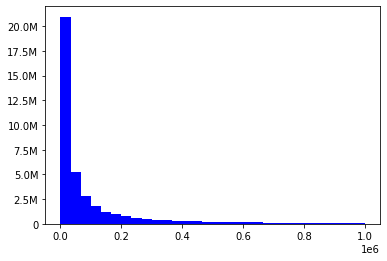

In [6]:
fig, ax = plt.subplots()
hist(ax, df.select('Monto_IVA'), bins = 30, color=['blue'])

Ahora calculamos la fraccion de IVA para cada contriibuyente A que ha generado documentos tributarios al contribuyente B.

In [7]:
spark.sql("SELECT PARU_RUT_E0, PARU_RUT_E2, Monto_IVA FROM comercial where Monto_IVA>0 order by PARU_RUT_E2 asc").createOrReplaceTempView("comercial")
spark.sql("SELECT PARU_RUT_E2, sum(Monto_IVA) as Total_IVA FROM comercial group by PARU_RUT_E2 order by PARU_RUT_E2 asc").createOrReplaceTempView("comercial_aux")
spark.sql("SELECT PARU_RUT_E0,comercial.PARU_RUT_E2,ROUND(Monto_IVA/Total_IVA,4) as Fi from comercial left join comercial_aux on comercial.PARU_RUT_E2= comercial_aux.PARU_RUT_E2").createOrReplaceTempView("comercial")

In [8]:
spark.sql("SELECT PARU_RUT_E0 as emisor, PARU_RUT_E2 as receptor,  Fi from comercial where Fi>0 order by Fi desc").show()

+--------------------+--------------------+---+
|              emisor|            receptor| Fi|
+--------------------+--------------------+---+
|B8NbUXvRNiLu2GkH5...|++ofNY9yNu8MZ4sNq...|1.0|
|vFpjRDRrOH20Hqatg...|+/WKXGMzM+d2Mfsw4...|1.0|
|Hug0GU2sG4iH4o6T8...|++s6oPIgTC6w8+fUR...|1.0|
|huoACB11ybPdKaqeo...|++2WR3jidynmqlWNZ...|1.0|
|huoACB11ybPdKaqeo...|+/Wi2GrAHA8H4IhBg...|1.0|
|3Cdj0g6NT+NHyz2AB...|++ghs4qXDe0sGgk5F...|1.0|
|49ZXqpJdvqnjViFZh...|+/QXOLqeLl7qFRpym...|1.0|
|8EhgbX7RVuJqj8tDW...|++zYI2xUyxYd5mQI9...|1.0|
|MR24FM3vMr1CLsK38...|++WhHtmAMqjzaSmQz...|1.0|
|EoRqec9D5xJHAUyct...|+/49byUHgv6jOPLPF...|1.0|
|uzReUMIJZOdu8AfAi...|++wHFQ0R1A5R9qjng...|1.0|
|Rx4SIznv6p6TVO2dS...|+/59WVm/1ziRJ6oxj...|1.0|
|fuFk9eTEZrmT3oDuC...|++jV7AaSlvC4xgrOs...|1.0|
|SR1uHiJfuh92SmpAE...|+/6AB1uw9OtAXFtM9...|1.0|
|LKwb0G/fYUGmbf1xY...|++mAylJUFlbYPONmi...|1.0|
|BfoPgOL56jXsJpxoH...|++hTorcNVPc+n49fK...|1.0|
|9mHlMg9kVaSfTxNFm...|++bPlKwDqmqbRo/ho...|1.0|
|vtjm1wZPvgVBPhGYi...|++jUrtXG240okyC0V.

Finalmente guardamos la data para poder utilizarla posteriormente en la propagacion. 

In [ ]:
iva=spark.sql("SELECT PARU_RUT_E0 as emisor, PARU_RUT_E2 as receptor, Fi from comercial").toPandas()
iva.to_csv(f'/home/cdsw/data/processed/{Carpeta_Salida}fuerza_iva.csv', index=False)